Важные замечания!!!

1. Файл должен называться DailyDelhiClimateTrain.csv и находится в одной папке с этим файлом/кодом
2. Установить/написать в терминале: pip install pandas numpy matplotlib seaborn scikit-learn scipy fastdtw tslearn
3. Запускать: Python Environments... --> +Create Python Environment --> venv --> Python 3.?

# Практическая часть: кластеризация временных паттернов и корреляция признаков (Delhi Climate)

Цель:
1) Очистить и нормализовать временные ряды.
2) Разбить ряд на сегменты фиксированной длины (например, 30 дней).
3) Сгруппировать похожие сегменты (K-Means и Hierarchical clustering).
4) Проанализировать корреляции признаков (Pearson/Spearman/Kendall).
5) Визуализировать результаты (кластеры и heatmap корреляций).

In [2]:
# ============================================
# 1) Импорт необходимых библиотек
# ============================================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

import warnings
warnings.filterwarnings("ignore")

# В ноутбуке VS Code часто не нужно, но пусть будет:
%matplotlib inline


## Шаг 1. Загрузка данных

Мы загрузим CSV с погодными показателями Дели.
Далее приведём дату к формату datetime, сделаем её индексом и отсортируем данные по времени.


In [3]:
# ============================================
# 2) Загрузка данных из CSV
# ============================================

data_path = "DailyDelhiClimateTrain.csv"  # файл должен лежать рядом с ноутбуком

df = pd.read_csv(data_path)

# Посмотрим первые строки
display(df.head())

# Посмотрим структуру таблицы
print(df.info())


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB
None


In [4]:
# ============================================
# 3) Приведение даты и установка индекса
# ============================================

# Превращаем колонку date в тип datetime
df["date"] = pd.to_datetime(df["date"])

# Делаем date индексом и сортируем по времени (важно для временных рядов)
df = df.set_index("date").sort_index()

display(df.head())
print("Период данных:", df.index.min(), "->", df.index.max())


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


Период данных: 2017-01-01 00:00:00 -> 2017-04-24 00:00:00


## Шаг 2. Очистка и подготовка данных

Мы проверим пропуски и обработаем их.
Затем выберем нужные признаки и нормализуем их, чтобы разные шкалы (температура, влажность и т.д.) не ломали анализ.


In [5]:
# ============================================
# 4) Проверка пропусков и их обработка
# ============================================

print("Пропуски в исходных данных:")
print(df.isna().sum())

# Для временных рядов часто используют интерполяцию по времени:
df_interpolated = df.interpolate(method="time")

print("\nПропуски после интерполяции:")
print(df_interpolated.isna().sum())


Пропуски в исходных данных:
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Пропуски после интерполяции:
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [6]:
# ============================================
# 5) Выбор признаков (столбцов) для анализа
# ============================================

# В этом датасете обычно есть:
# meantemp, humidity, wind_speed, meanpressure
features = ["meantemp", "humidity", "wind_speed", "meanpressure"]

data = df_interpolated[features].copy()

display(data.head())


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [7]:
# ============================================
# 6) Нормализация (StandardScaler)
# ============================================

# StandardScaler делает: (x - среднее) / стандартное_отклонение
# Это важно, чтобы все признаки были в одном масштабе.
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

data_scaled_df = pd.DataFrame(
    data_scaled,
    index=data.index,
    columns=features
)

display(data_scaled_df.head())


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,-0.915971,1.559776,-1.511765,-10.608670
2017-01-02,-0.507426,1.104275,-1.469505,0.159884
2017-01-03,-0.726766,1.350093,-1.155357,0.160508
2017-01-04,-0.475841,0.726477,-1.007459,0.130947
2017-01-05,-0.524973,0.984293,-1.355976,0.115605


## Шаг 3. Визуализация нормализованных временных рядов

Построим график всех признаков, чтобы увидеть общую динамику и сезонность.


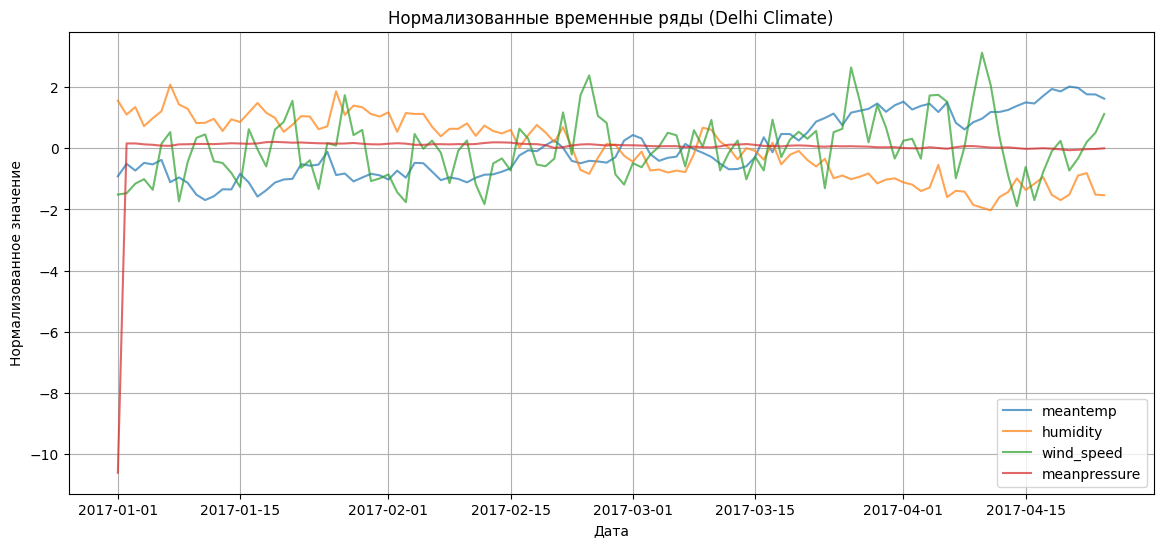

In [8]:
# ============================================
# 7) Визуализация временных рядов
# ============================================

plt.figure(figsize=(14, 6))

for col in features:
    plt.plot(data_scaled_df.index, data_scaled_df[col], label=col, alpha=0.7)

plt.title("Нормализованные временные ряды (Delhi Climate)")
plt.xlabel("Дата")
plt.ylabel("Нормализованное значение")
plt.legend()
plt.grid(True)
plt.show()


## Шаг 4. Сегментация временного ряда

Чтобы кластеризовать паттерны, мы превращаем один длинный ряд в набор коротких сегментов.
Например, сегмент длиной 30 дней — это "месячный паттерн".

Каждый сегмент станет отдельным объектом, который мы будем сравнивать и кластеризовать.


In [9]:
# ============================================
# 8) Сегментация временного ряда
# ============================================

window_size = 30  # длина сегмента (30 дней)

# Для простоты сначала берём только температуру
series = data_scaled_df["meantemp"].values

def create_segments(series, index, window_size):
    """
    Разбиваем одномерный временной ряд на НЕперекрывающиеся сегменты длиной window_size.

    series: массив значений (например, температура)
    index: временной индекс (даты)
    window_size: длина сегмента

    Возвращает:
    segments: np.array формы (n_segments, window_size)
    segment_start_dates: список дат начала каждого сегмента
    """
    n = len(series)
    n_segments = n // window_size  # сколько целых сегментов помещается

    segments = []
    segment_start_dates = []

    for i in range(n_segments):
        start = i * window_size
        end = start + window_size

        segments.append(series[start:end])
        segment_start_dates.append(index[start])  # дата начала сегмента

    return np.array(segments), segment_start_dates

segments, segment_start_dates = create_segments(series, data_scaled_df.index, window_size)

print("Количество сегментов:", len(segments))
print("Размер каждого сегмента:", segments.shape)
print("Первые 5 дат начала сегментов:", segment_start_dates[:5])


Количество сегментов: 3
Размер каждого сегмента: (3, 30)
Первые 5 дат начала сегментов: [Timestamp('2017-01-01 00:00:00'), Timestamp('2017-01-31 00:00:00'), Timestamp('2017-03-02 00:00:00')]


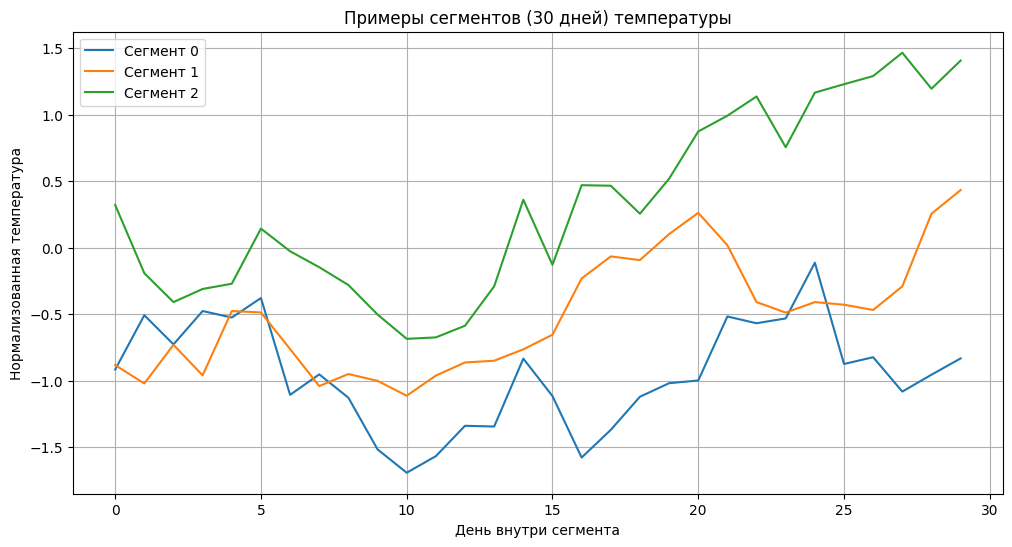

In [10]:
# ============================================
# 9) Визуализация нескольких сегментов
# ============================================

plt.figure(figsize=(12, 6))

for i in range(min(5, len(segments))):
    plt.plot(range(window_size), segments[i], label=f"Сегмент {i}")

plt.title("Примеры сегментов (30 дней) температуры")
plt.xlabel("День внутри сегмента")
plt.ylabel("Нормализованная температура")
plt.legend()
plt.grid(True)
plt.show()


## Шаг 5. Кластеризация сегментов методом K-Means (Евклид)

Здесь каждый сегмент — это вектор длины 30.
K-Means попытается разделить сегменты на k групп с похожей формой.


In [11]:
# ============================================
# 10) K-Means кластеризация сегментов (Евклид)
# ============================================

n_clusters_kmeans = 3

kmeans = KMeans(
    n_clusters=n_clusters_kmeans,
    random_state=42,
    n_init=10
)

kmeans_labels = kmeans.fit_predict(segments)

print("Первые 20 меток кластеров (K-Means):")
print(kmeans_labels[:20])


Первые 20 меток кластеров (K-Means):
[2 0 1]


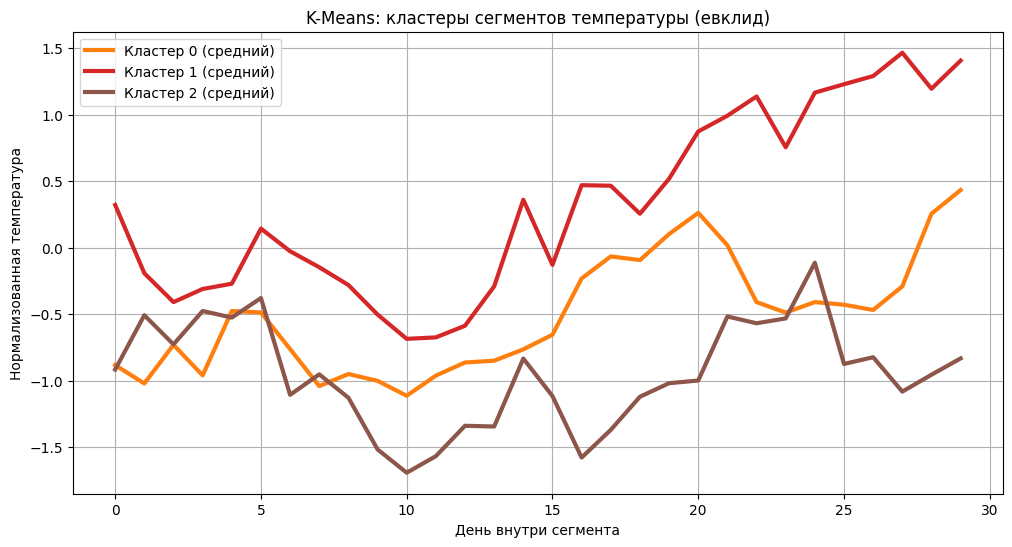

In [12]:
# ============================================
# 11) Визуализация сегментов по кластерам (K-Means)
# ============================================

plt.figure(figsize=(12, 6))

for cluster_id in range(n_clusters_kmeans):
    cluster_segments = segments[kmeans_labels == cluster_id]

    # Отрисуем все сегменты кластера полупрозрачно
    for seg in cluster_segments:
        plt.plot(seg, alpha=0.2)

    # Средний паттерн кластера
    centroid = cluster_segments.mean(axis=0)
    plt.plot(centroid, linewidth=3, label=f"Кластер {cluster_id} (средний)")

plt.title("K-Means: кластеры сегментов температуры (евклид)")
plt.xlabel("День внутри сегмента")
plt.ylabel("Нормализованная температура")
plt.legend()
plt.grid(True)
plt.show()


## Шаг 6. DTW + Иерархическая кластеризация

DTW (Dynamic Time Warping) позволяет сравнивать временные сегменты,
даже если похожие "пики" и "спады" немного смещены по времени.

План:
1) Посчитать DTW-расстояние между каждым парой сегментов → получим матрицу расстояний.
2) Запустить иерархическую кластеризацию по этой матрице.


In [13]:
# ============================================
# 12) Реализация DTW и расчёт матрицы расстояний
# ============================================

def dtw_distance(s1, s2):
    """
    DTW расстояние между двумя одномерными рядами.
    Реализация через динамическое программирование.

    Важно: это не самая быстрая версия, но понятная и учебная.
    """
    s1 = np.array(s1, dtype=float)
    s2 = np.array(s2, dtype=float)

    n, m = len(s1), len(s2)

    # dp[i, j] = минимальная стоимость выравнивания первых i элементов s1 и первых j элементов s2
    dp = np.full((n + 1, m + 1), np.inf)
    dp[0, 0] = 0.0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(s1[i - 1] - s2[j - 1])  # стоимость "сопоставить" эти точки
            dp[i, j] = cost + min(
                dp[i - 1, j],     # пришли сверху (пропуск в s2)
                dp[i, j - 1],     # пришли слева (пропуск в s1)
                dp[i - 1, j - 1]  # пришли по диагонали (сопоставили)
            )

    return dp[n, m]

# Посчитаем DTW-матрицу
n_segments = len(segments)
dtw_matrix = np.zeros((n_segments, n_segments))

# Чтобы не считать дважды, считаем только верхний треугольник и копируем
for i in range(n_segments):
    for j in range(i + 1, n_segments):
        dist = dtw_distance(segments[i], segments[j])
        dtw_matrix[i, j] = dist
        dtw_matrix[j, i] = dist

print("DTW-матрица посчитана. Размер:", dtw_matrix.shape)


DTW-матрица посчитана. Размер: (3, 3)


In [14]:
# ============================================
# 13) Иерархическая кластеризация по DTW-матрице
# (В новых sklearn вместо affinity используется metric)
# ============================================

n_clusters_hier = 3

hier_clust = AgglomerativeClustering(
    n_clusters=n_clusters_hier,
    metric="precomputed",   # говорим, что X - это матрица расстояний
    linkage="average"       # среднее расстояние между кластерами
)

hier_labels = hier_clust.fit_predict(dtw_matrix)

print("Первые 20 меток кластеров (Hierarchical + DTW):")
print(hier_labels[:20])


Первые 20 меток кластеров (Hierarchical + DTW):
[2 1 0]


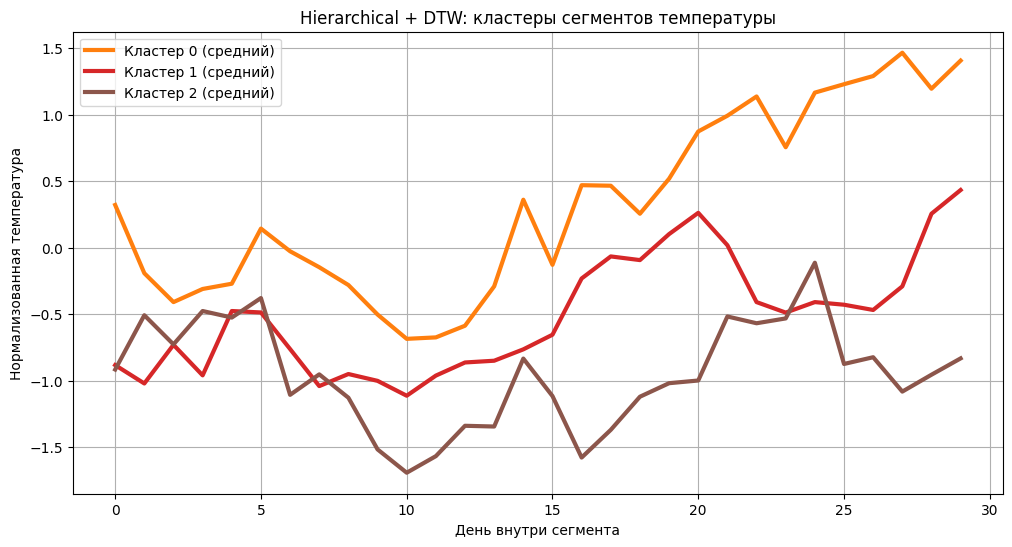

In [15]:
# ============================================
# 14) Визуализация сегментов по кластерам (Hierarchical + DTW)
# ============================================

plt.figure(figsize=(12, 6))

for cluster_id in range(n_clusters_hier):
    cluster_segments = segments[hier_labels == cluster_id]

    for seg in cluster_segments:
        plt.plot(seg, alpha=0.2)

    centroid = cluster_segments.mean(axis=0)
    plt.plot(centroid, linewidth=3, label=f"Кластер {cluster_id} (средний)")

plt.title("Hierarchical + DTW: кластеры сегментов температуры")
plt.xlabel("День внутри сегмента")
plt.ylabel("Нормализованная температура")
plt.legend()
plt.grid(True)
plt.show()


## Шаг 7. Корреляционный анализ признаков

Теперь мы исследуем связи между признаками:
- температура
- влажность
- ветер
- давление

Посчитаем 3 вида корреляций:
- Pearson: линейная связь
- Spearman: монотонная (по рангам)
- Kendall: ранговая, устойчива к шуму


In [16]:
# ============================================
# 15) Корреляции (Pearson, Spearman, Kendall)
# ============================================

corr_pearson  = data_scaled_df.corr(method="pearson")
corr_spearman = data_scaled_df.corr(method="spearman")
corr_kendall  = data_scaled_df.corr(method="kendall")

print("Pearson корреляция:")
display(corr_pearson)

print("Spearman корреляция:")
display(corr_spearman)

print("Kendall корреляция:")
display(corr_kendall)


Pearson корреляция:


,meantemp,humidity,wind_speed,meanpressure
meantemp,1.000000,-0.857726,0.217743,0.030682
humidity,-0.857726,1.000000,-0.340507,-0.097869
wind_speed,0.217743,-0.340507,1.000000,0.130352
meanpressure,0.030682,-0.097869,0.130352,1.000000


Spearman корреляция:


,meantemp,humidity,wind_speed,meanpressure
meantemp,1.000000,-0.849129,0.194265,-0.827740
humidity,-0.849129,1.000000,-0.283746,0.729457
wind_speed,0.194265,-0.283746,1.000000,-0.179943
meanpressure,-0.827740,0.729457,-0.179943,1.000000


Kendall корреляция:


,meantemp,humidity,wind_speed,meanpressure
meantemp,1.000000,-0.639776,0.130567,-0.656252
humidity,-0.639776,1.000000,-0.194686,0.540242
wind_speed,0.130567,-0.194686,1.000000,-0.125078
meanpressure,-0.656252,0.540242,-0.125078,1.000000


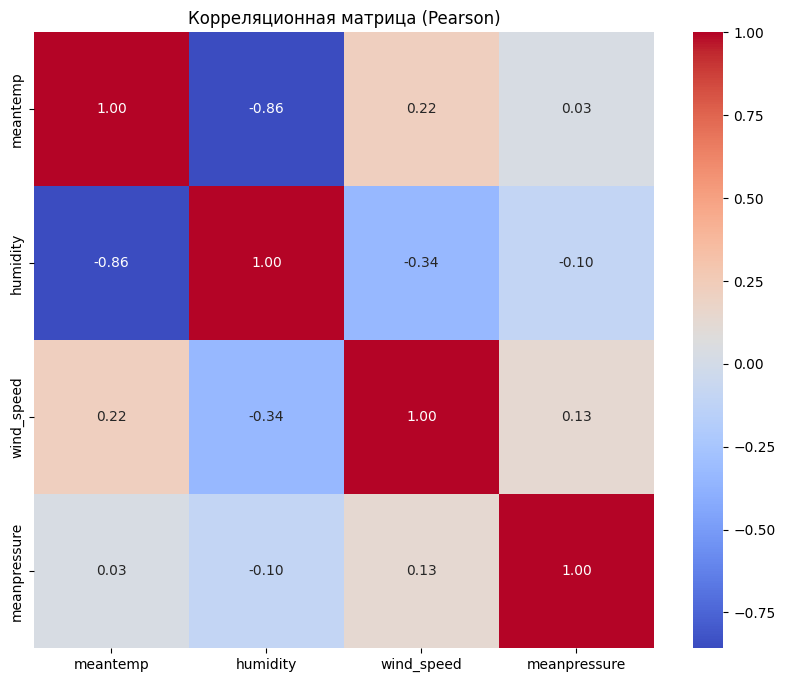

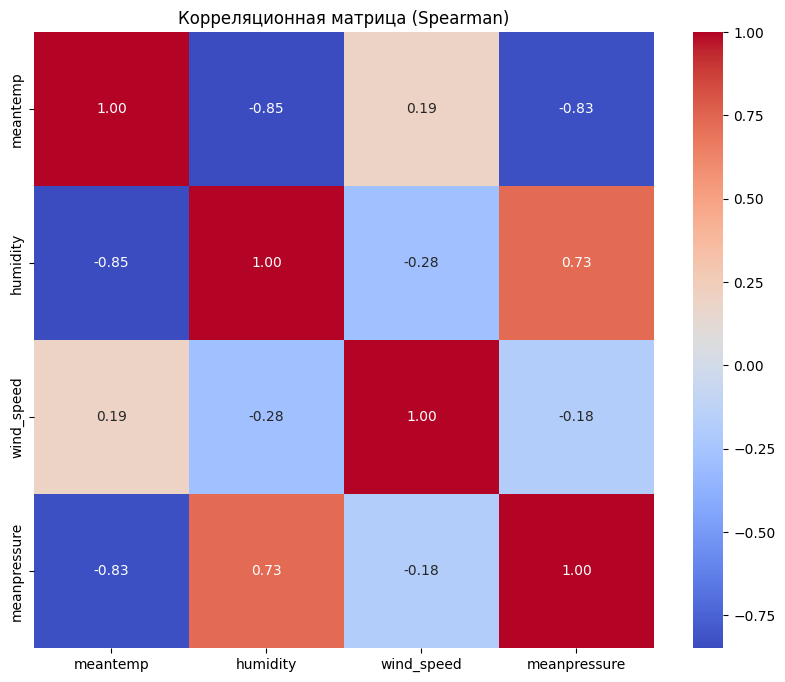

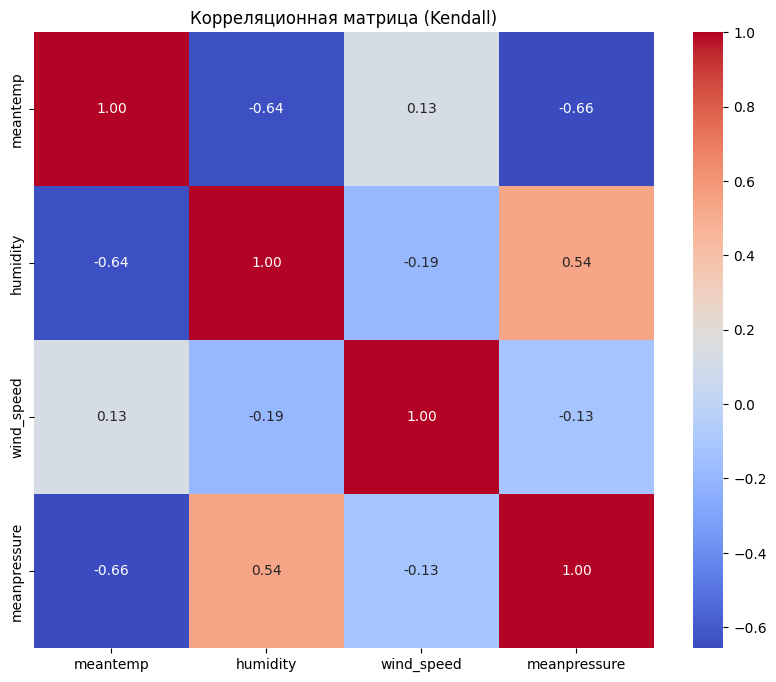

In [17]:
# ============================================
# 16) Визуализация heatmap корреляций
# ============================================

plt.figure(figsize=(10, 8))
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица (Pearson)")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица (Spearman)")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_kendall, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица (Kendall)")
plt.show()


## Интерпретация результатов (пример текста)

1) **K-Means (евклид):**  
   Сегменты температуры группируются по похожей форме (например, холодные/тёплые периоды).  
   Средняя линия кластера показывает “типичный” паттерн этой группы.

2) **Hierarchical + DTW:**  
   DTW учитывает сдвиги, поэтому сегменты с похожими пиками/спадами, но сдвинутые по времени,
   всё равно могут попасть в один кластер. Это особенно полезно для сезонности.

3) **Корреляции:**  
   Heatmap показывает взаимосвязи: например, температура может иметь отрицательную корреляцию
   с давлением или зависимость с влажностью. Разные методы корреляции помогают увидеть
   как линейные, так и ранговые связи.
